Для первой лабораторной работы был выбран датасет подкастов. Это задача регрессии; необходимо предсказать время прослушивания конкретного выпуска.
Это полноценное соревнование(competition), поэтому есть чётко поставленная задача, следовательно требования лабораторной работы соблюдены.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"m0le79799","key":"a74814da08d3b2e3b45764667be9feb4"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s5e4

In [ ]:
import shutil
shutil.unpack_archive("/content/playground-series-s5e4.zip",
                      "/content/playground-series-s5e4")

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [ ]:
train = pd.read_csv('/content/playground-series-s5e4/train.csv')
test = pd.read_csv('/content/playground-series-s5e4/test.csv')

## Analise and preprocessing

In [ ]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


<Axes: xlabel='Listening_Time_minutes', ylabel='Count'>

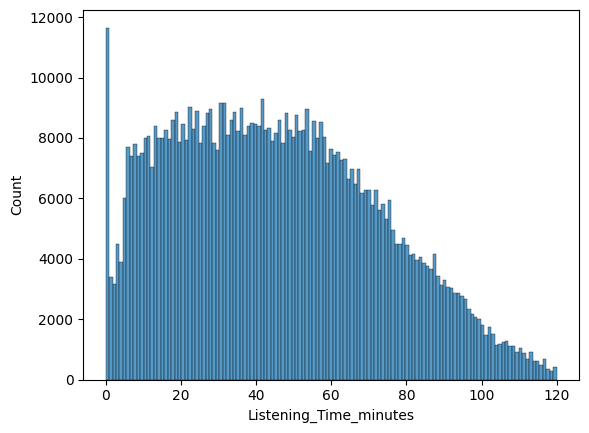

In [ ]:
sns.histplot(train['Listening_Time_minutes'])

In [ ]:
def outliers_processing(df):
    df = df[df['Listening_Time_minutes'] >= 1]
    return df

train_prep = outliers_processing(train)

print(f'Train: {len(train)} -> {len(train_prep)}')

Train: 750000 -> 738077


<Axes: xlabel='Listening_Time_minutes', ylabel='Count'>

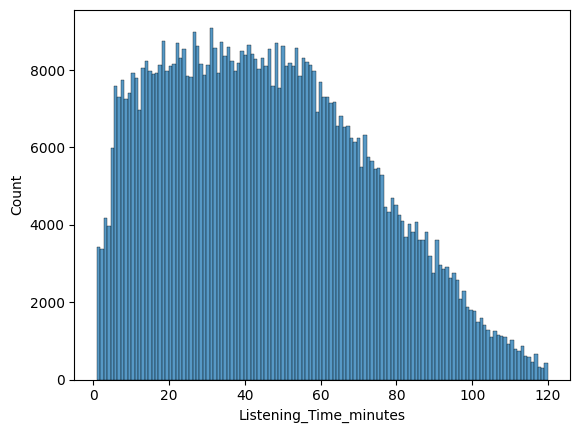

In [ ]:
sns.histplot(train_prep['Listening_Time_minutes'])

In [ ]:
def fill_missing_values(df):
    df['Episode_Length_minutes'] = df['Episode_Length_minutes'].fillna(df['Episode_Length_minutes'].median())
    df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].fillna(df['Guest_Popularity_percentage'].median())
    df['Number_of_Ads'] = df['Number_of_Ads'].fillna(df['Number_of_Ads'].mode()[0])
    df.loc[df['Number_of_Ads'] > 4, 'Number_of_Ads'] = df['Number_of_Ads'].mode()[0]

    return df

train_prep = fill_missing_values(train_prep)
test_prer = fill_missing_values(test)

In [ ]:
def feature_engineering(df):
    df['Episode_Number'] = df['Episode_Title'].str.extract(r'(\d+)').astype(float)
    df = df.drop('Episode_Title', axis=1)
    return df

train_prep = feature_engineering(train_prep)
test_prer = feature_engineering(test_prer)

In [ ]:
def encode_categorical_columns(df):
    obj_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
    df = pd.get_dummies(df,columns=obj_cols)
    return df

train_prep = encode_categorical_columns(train_prep)
test_prer = encode_categorical_columns(test_prer)

In [ ]:
train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738077 entries, 0 to 749999
Data columns (total 79 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                738077 non-null  int64  
 1   Episode_Length_minutes            738077 non-null  float64
 2   Host_Popularity_percentage        738077 non-null  float64
 3   Guest_Popularity_percentage       738077 non-null  float64
 4   Number_of_Ads                     738077 non-null  float64
 5   Listening_Time_minutes            738077 non-null  float64
 6   Episode_Number                    738077 non-null  float64
 7   Podcast_Name_Athlete's Arena      738077 non-null  bool   
 8   Podcast_Name_Brain Boost          738077 non-null  bool   
 9   Podcast_Name_Business Briefs      738077 non-null  bool   
 10  Podcast_Name_Business Insights    738077 non-null  bool   
 11  Podcast_Name_Comedy Corner        738077 non-null  bool  

<Axes: >

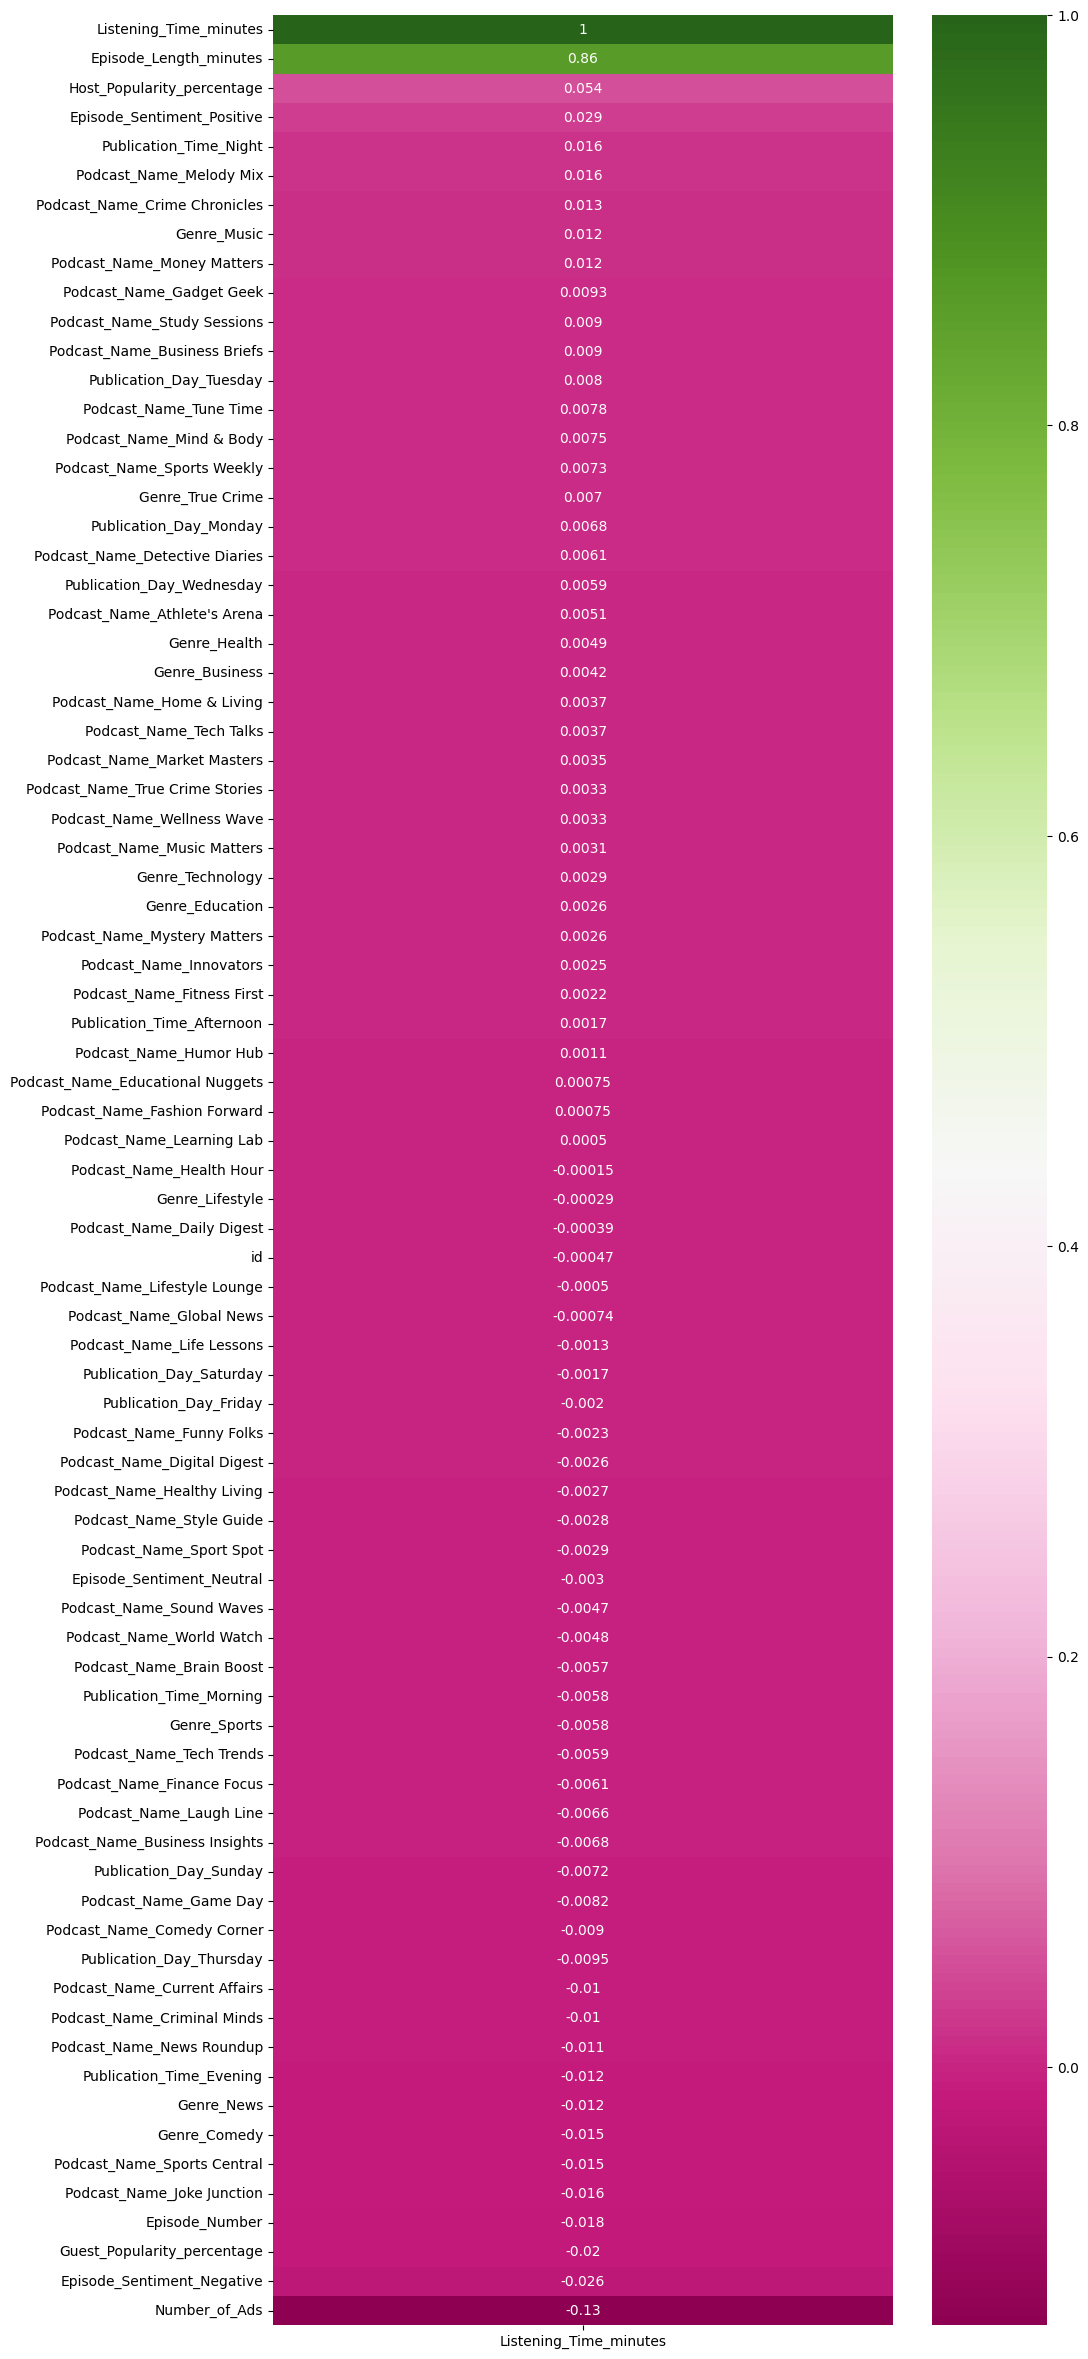

In [ ]:
cormat = train_prep.corr(numeric_only=True)


plt.figure(figsize=(10, 30))
sns.heatmap(cormat[['Listening_Time_minutes']].sort_values(by=['Listening_Time_minutes'], ascending=False), annot=True, cmap='PiYG')

In [ ]:
y = train_prep['Listening_Time_minutes']
X = train_prep.drop('Listening_Time_minutes', axis=1)

X_tr, X_val, y_tr, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
scaler = StandardScaler().fit(X_tr)

X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_prer)

In [ ]:
# X_tr = np.float32(np.array(X_tr))
# X_val = np.float32(np.array(X_val))
# X_test = np.float32(np.array(test_prer))

y_tr = np.array(y_tr)
y_val = np.array(y_val)


# Neural network engeneering

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T
from tqdm import tqdm

In [ ]:
! pip install torchinfo
from torchinfo import summary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cpu'

In [ ]:
class PodcastDataset(Dataset):
    def __init__(self, data, targets, transform=None) -> None:
        self.data = torch.Tensor(data)
        self.targets = torch.Tensor(targets).unsqueeze(1)
        self.transform = transform

    def __getitem__(self, index) -> list[torch.Tensor, torch.Tensor]:
        return [self.data[index], self.targets[index]]

    def __len__(self) -> int:
        return len(self.data)

train_dataset = PodcastDataset(X_tr, y_tr)
val_dataset = PodcastDataset(X_val, y_val)

In [ ]:
len(train_dataset[0][0])

78

In [ ]:
batch_size = 512

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = nn.Sequential(
    nn.Linear(78, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
summary(model, input_size=(1,78))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─Linear: 1-1                            [1, 128]                  10,112
├─ReLU: 1-2                              [1, 128]                  --
├─BatchNorm1d: 1-3                       [1, 128]                  256
├─Dropout: 1-4                           [1, 128]                  --
├─Linear: 1-5                            [1, 64]                   8,256
├─ReLU: 1-6                              [1, 64]                   --
├─BatchNorm1d: 1-7                       [1, 64]                   128
├─Dropout: 1-8                           [1, 64]                   --
├─Linear: 1-9                            [1, 32]                   2,080
├─ReLU: 1-10                             [1, 32]                   --
├─Linear: 1-11                           [1, 1]                    33
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
Tot

In [ ]:
train_losses = []
def train(model, epoch):
    print(f'Epoch: {epoch}')
    model.train()
    running_loss = 0
    for data in tqdm(train_loader):
        inputs, targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss)
    print(f'Train MSE in epoch: {train_loss}')

In [ ]:
val_losses = []
def val(model, epoch):
    print(f'Epoch: {epoch}')
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data in tqdm(val_loader):
            inputs, targets = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

        val_loss = running_loss/len(val_loader)
        val_losses.append(val_loss)
        print(f'Validation MSE in epoch: {val_loss}')

In [ ]:
n_epoch = 30

for epoch in range(1, n_epoch+1):
    train(model, epoch)
    val(model, epoch)

Epoch: 1


100%|██████████| 4613/4613 [00:23<00:00, 193.79it/s]


Train MSE in epoch: 280.69696699035364
Epoch: 1


100%|██████████| 1154/1154 [00:02<00:00, 566.34it/s]


Validation MSE in epoch: 177.62012474417065
Epoch: 2


100%|██████████| 4613/4613 [00:23<00:00, 192.81it/s]


Train MSE in epoch: 198.5838309419716
Epoch: 2


100%|██████████| 1154/1154 [00:02<00:00, 553.16it/s]


Validation MSE in epoch: 177.00184207565863
Epoch: 3


100%|██████████| 4613/4613 [00:24<00:00, 190.15it/s]


Train MSE in epoch: 191.21600659343753
Epoch: 3


100%|██████████| 1154/1154 [00:02<00:00, 441.95it/s]


Validation MSE in epoch: 175.90890845392977
Epoch: 4


100%|██████████| 4613/4613 [00:25<00:00, 180.47it/s]


Train MSE in epoch: 186.75018044932142
Epoch: 4


100%|██████████| 1154/1154 [00:02<00:00, 436.84it/s]


Validation MSE in epoch: 176.40135755489356
Epoch: 5


100%|██████████| 4613/4613 [00:23<00:00, 198.15it/s]


Train MSE in epoch: 185.29989924204472
Epoch: 5


100%|██████████| 1154/1154 [00:03<00:00, 367.92it/s]


Validation MSE in epoch: 175.58194476149112
Epoch: 6


100%|██████████| 4613/4613 [00:23<00:00, 198.49it/s]


Train MSE in epoch: 183.9922333226761
Epoch: 6


100%|██████████| 1154/1154 [00:02<00:00, 434.36it/s]


Validation MSE in epoch: 175.49727485828632
Epoch: 7


100%|██████████| 4613/4613 [00:23<00:00, 192.60it/s]


Train MSE in epoch: 183.16922158324587
Epoch: 7


100%|██████████| 1154/1154 [00:02<00:00, 547.07it/s]


Validation MSE in epoch: 179.3558483090723
Epoch: 8


100%|██████████| 4613/4613 [00:24<00:00, 187.57it/s]


Train MSE in epoch: 182.3642188799296
Epoch: 8


100%|██████████| 1154/1154 [00:02<00:00, 443.55it/s]


Validation MSE in epoch: 174.7824980671319
Epoch: 9


100%|██████████| 4613/4613 [00:23<00:00, 194.75it/s]


Train MSE in epoch: 181.99758175647932
Epoch: 9


100%|██████████| 1154/1154 [00:02<00:00, 565.29it/s]


Validation MSE in epoch: 175.49530844465286
Epoch: 10


100%|██████████| 4613/4613 [00:23<00:00, 195.42it/s]


Train MSE in epoch: 181.4884514915124
Epoch: 10


100%|██████████| 1154/1154 [00:02<00:00, 560.92it/s]


Validation MSE in epoch: 174.95807314497551
Epoch: 11


100%|██████████| 4613/4613 [00:24<00:00, 191.39it/s]


Train MSE in epoch: 181.14775990127043
Epoch: 11


100%|██████████| 1154/1154 [00:02<00:00, 568.76it/s]


Validation MSE in epoch: 174.62268240282398
Epoch: 12


100%|██████████| 4613/4613 [00:23<00:00, 195.76it/s]


Train MSE in epoch: 180.67616513275206
Epoch: 12


100%|██████████| 1154/1154 [00:02<00:00, 456.84it/s]


Validation MSE in epoch: 175.53152662835873
Epoch: 13


100%|██████████| 4613/4613 [00:23<00:00, 198.85it/s]


Train MSE in epoch: 180.37356357338783
Epoch: 13


100%|██████████| 1154/1154 [00:03<00:00, 373.06it/s]


Validation MSE in epoch: 174.54426909897936
Epoch: 14


100%|██████████| 4613/4613 [00:24<00:00, 190.98it/s]


Train MSE in epoch: 180.4088025708119
Epoch: 14


100%|██████████| 1154/1154 [00:03<00:00, 357.14it/s]


Validation MSE in epoch: 174.4547099439069
Epoch: 15


100%|██████████| 4613/4613 [00:23<00:00, 193.46it/s]


Train MSE in epoch: 180.23015314478846
Epoch: 15


100%|██████████| 1154/1154 [00:02<00:00, 416.00it/s]


Validation MSE in epoch: 174.66481412758654
Epoch: 16


100%|██████████| 4613/4613 [00:24<00:00, 189.88it/s]


Train MSE in epoch: 179.78721008532327
Epoch: 16


100%|██████████| 1154/1154 [00:02<00:00, 510.36it/s]


Validation MSE in epoch: 174.612285673515
Epoch: 17


100%|██████████| 4613/4613 [00:24<00:00, 190.07it/s]


Train MSE in epoch: 179.54154694046758
Epoch: 17


100%|██████████| 1154/1154 [00:02<00:00, 547.78it/s]


Validation MSE in epoch: 174.16057763851703
Epoch: 18


100%|██████████| 4613/4613 [00:24<00:00, 190.18it/s]


Train MSE in epoch: 179.43475445165
Epoch: 18


100%|██████████| 1154/1154 [00:02<00:00, 546.41it/s]


Validation MSE in epoch: 174.14174909938765
Epoch: 19


100%|██████████| 4613/4613 [00:24<00:00, 190.22it/s]


Train MSE in epoch: 179.5445150263315
Epoch: 19


100%|██████████| 1154/1154 [00:02<00:00, 563.29it/s]


Validation MSE in epoch: 174.58037586311326
Epoch: 20


100%|██████████| 4613/4613 [00:23<00:00, 192.67it/s]


Train MSE in epoch: 179.23507742196443
Epoch: 20


100%|██████████| 1154/1154 [00:02<00:00, 550.29it/s]


Validation MSE in epoch: 174.77885431061586
Epoch: 21


100%|██████████| 4613/4613 [00:24<00:00, 191.90it/s]


Train MSE in epoch: 179.18931994054677
Epoch: 21


100%|██████████| 1154/1154 [00:02<00:00, 571.30it/s]


Validation MSE in epoch: 173.90262867549058
Epoch: 22


100%|██████████| 4613/4613 [00:22<00:00, 202.78it/s]


Train MSE in epoch: 179.04611340681333
Epoch: 22


100%|██████████| 1154/1154 [00:03<00:00, 375.84it/s]


Validation MSE in epoch: 173.75052034586307
Epoch: 23


100%|██████████| 4613/4613 [00:22<00:00, 209.19it/s]


Train MSE in epoch: 178.84313217120084
Epoch: 23


100%|██████████| 1154/1154 [00:02<00:00, 507.01it/s]


Validation MSE in epoch: 174.14497477962817
Epoch: 24


100%|██████████| 4613/4613 [00:23<00:00, 197.23it/s]


Train MSE in epoch: 178.77801069437024
Epoch: 24


100%|██████████| 1154/1154 [00:02<00:00, 565.36it/s]


Validation MSE in epoch: 174.21581122862818
Epoch: 25


100%|██████████| 4613/4613 [00:24<00:00, 190.13it/s]


Train MSE in epoch: 178.62559827651168
Epoch: 25


100%|██████████| 1154/1154 [00:02<00:00, 543.20it/s]


Validation MSE in epoch: 173.83686476894226
Epoch: 26


100%|██████████| 4613/4613 [00:23<00:00, 192.62it/s]


Train MSE in epoch: 178.56031127010124
Epoch: 26


100%|██████████| 1154/1154 [00:02<00:00, 545.66it/s]


Validation MSE in epoch: 173.8532721719461
Epoch: 27


100%|██████████| 4613/4613 [00:24<00:00, 190.28it/s]


Train MSE in epoch: 178.4566206999257
Epoch: 27


100%|██████████| 1154/1154 [00:04<00:00, 241.23it/s]


Validation MSE in epoch: 173.96528205012117
Epoch: 28


100%|██████████| 4613/4613 [00:25<00:00, 179.22it/s]


Train MSE in epoch: 178.46728564414755
Epoch: 28


100%|██████████| 1154/1154 [00:02<00:00, 550.79it/s]


Validation MSE in epoch: 173.95809049953414
Epoch: 29


100%|██████████| 4613/4613 [00:24<00:00, 190.32it/s]


Train MSE in epoch: 178.29151377501157
Epoch: 29


100%|██████████| 1154/1154 [00:02<00:00, 549.87it/s]


Validation MSE in epoch: 173.9334744035268
Epoch: 30


100%|██████████| 4613/4613 [00:24<00:00, 191.66it/s]


Train MSE in epoch: 178.19117586643196
Epoch: 30


100%|██████████| 1154/1154 [00:02<00:00, 552.17it/s]

Validation MSE in epoch: 173.99060576255442


In [ ]:
losses = pd.DataFrame({'Train loss' : train_losses, 'Validation loss': val_losses})

<Axes: >

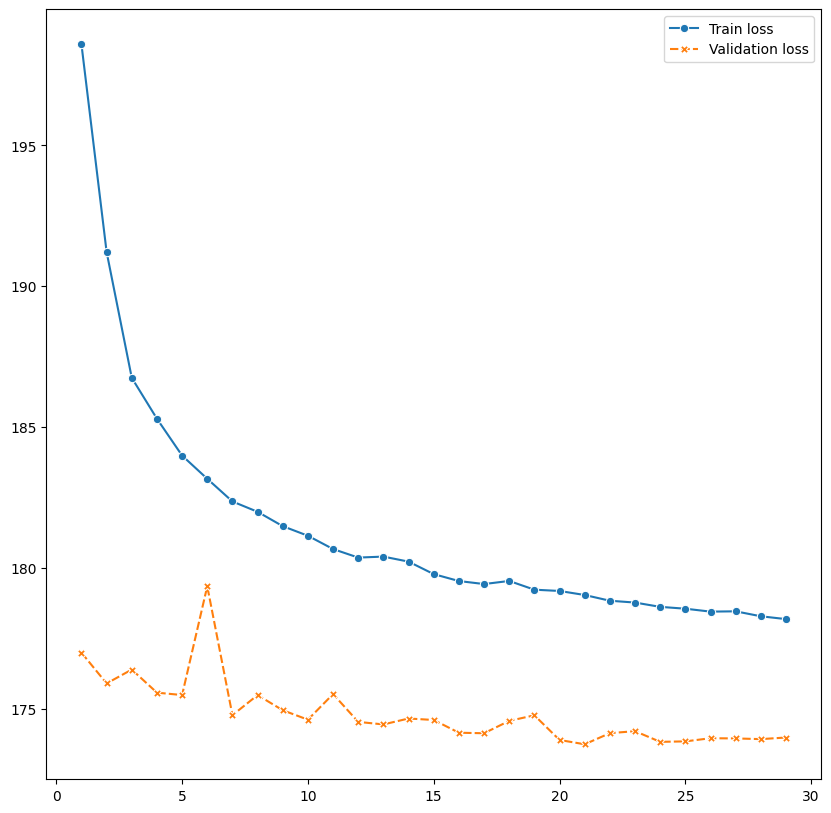

In [ ]:
plt.figure(figsize=(10, 10))
sns.lineplot(losses[1:], markers=True)

In [ ]:
X_test_tensor = torch.Tensor(X_test).to(device)

with torch.no_grad():
    results = model(X_test_tensor)

print(results)

tensor([[54.5399],
        [18.7427],
        [46.4888],
        ...,
        [ 7.2329],
        [76.3392],
        [58.2648]])


In [ ]:
subm = pd.DataFrame({
    'id': np.arange(750000, 750000 + len(X_test)),
    'Listening_Time_minutes': results.cpu().squeeze().detach().numpy()
})

subm.to_csv('subm.csv', index=False)

За проверку модели я решил считать её результат в соревновании Kaggle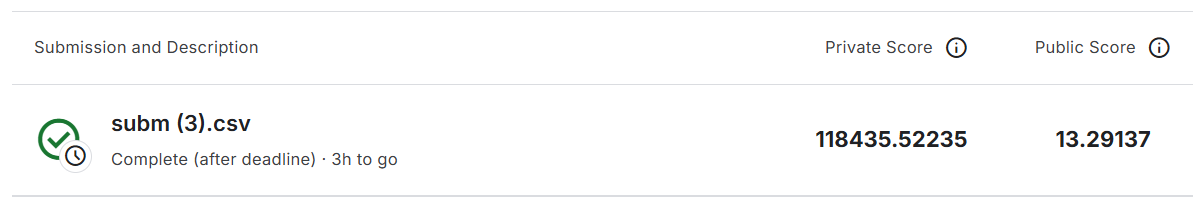
Результат представлен в public score в RMSE.

У лидера этого соревнования результат: 11.5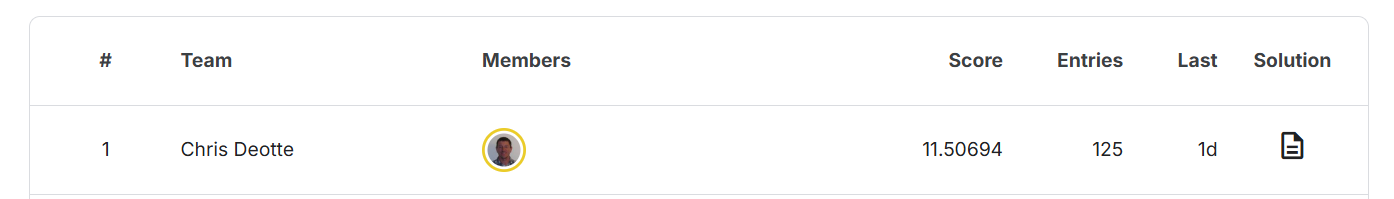